# Generate DEA Hotspots animations <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)


## Description
This notebook loads DEA Hotspots data for a given time and location, and animates the data over a 2018 Geomedian underlay with fading colours that represent the age of the hotspot.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
import os
import datacube
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import sys
sys.path.append('../Scripts')
from dea_spatialtools import xr_rasterize

# # Create custom cmap with dark grey at end 
fires_cmap = get_cmap('YlOrRd')
# fires_cmap.set_over('#111211')

dc = datacube.Datacube(app="DEA_hotspots")

# boundary = gpd.read_file('https://data.gov.au/geoserver/nsw-state-boundary/wfs?request=GetFeature&typeName=ckan_a1b278b1_59ef_4dea_8468_50eb09967f18&outputFormat=json')
boundary = gpd.read_file('https://raw.githubusercontent.com/rowanhogan/australian-states/master/states.geojson').simplify(tolerance=0.02)




## Parameters

Set parameters used to load and visualise DEA Hotspots data

In [2]:
# # Setup params
# name = 'actfire'  # name used for output files
# time_period = 15  # days from current date to include in animation (e.g. a month or week of data)
# to_date = (dt.datetime.today() + dt.timedelta(days=1)).strftime('%Y-%m-%d')
# from_date = (dt.datetime.today() - dt.timedelta(days=time_period)).strftime('%Y-%m-%d')
# y_max, x_min = -35.38, 148.68  # top left coordinates of bbox
# y_min, x_max = -36.02, 149.32  # bottom right coordinates of bbox
# min_confidence = 0  # minimum confidence value of hotspots to include in animation
# max_features = 900000  # maximum features to load from WFS
# avhrr=False

# Setup params
name = 'eastcoast'  # name used for output files
from_date = '2019-09-01'
to_date = '2020-02-15'
y_max, x_min = -27.00, 142.5  # top left coordinates of bbox
y_min, x_max = -39.2, 154.7  # bottom right coordinates of bbox
min_confidence = 49  # minimum confidence value of hotspots to include in animation
max_features = 3000000  # maximum features to load from WFS
avhrr=False
modis=True
viirs=True

# Visualisation params
frame_freq = '4H'  # frequency used to generate animation frames (e.g. one frame every 3 hours). Smaller numbers create longer, smoother animations but take longer to render
hotspots_markersize = 2.5  # size to plot hotspots on map
hotspots_alpha = 0.15  # transperancy to plot hotspots on map
fade_hours = 96  # hours used to fade hotspots from yellow to black
geomedian_res = 0.03  # resolution in degrees to load geomedian underlay (smaller = slower rendering)

## Load and clean hotspots data

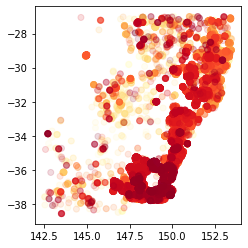

In [3]:
# Load WFS query data
avhrr_string = '(sensor=%27AVHRR%27%20AND%20(product=%27SRSS%27))%20OR%20' if avhrr else ''
modis_string = '(sensor=%27MODIS%27%20AND%20(product=%27MOD14%27))%20OR%20' if modis else ''
viirs_string = '(sensor=%27VIIRS%27%20AND%20(product=%27AFMOD%27%20OR%20product=%27EDR%27))' if viirs else ''
url = f"https://hotspots.dea.ga.gov.au/geoserver/public/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=public:hotspots&outputFormat=application/json&CQL_FILTER=({avhrr_string}{modis_string}{viirs_string})%20AND%20datetime%20%3E%20%27{from_date}%27%20AND%20datetime%20%3C%20%27{to_date}%27%20AND%20INTERSECTS(location,%20POLYGON(({y_min}%20{x_min},%20{y_min}%20{x_max},%20{y_max}%20{x_max},%20{y_max}%20{x_min},%20{y_min}%20{x_min})))&maxFeatures={max_features}&startIndex=0&sortBy=sensor%20A"
hotspots_gdf = gpd.read_file(url)
hotspots_gdf

# Filter by confidence
hotspots_gdf = hotspots_gdf.loc[hotspots_gdf.confidence >= min_confidence]

# Fix datetime
hotspots_gdf['datetime'] = pd.to_datetime(hotspots_gdf['start_dt'])

# Extract required columns
hotspots_gdf = hotspots_gdf.loc[:, [
    'datetime', 'latitude', 'longitude', 'temp_kelvin', 'confidence', 'geometry'
]]
hotspots_gdf.sort_values('datetime', ascending=True, inplace=True)
hotspots_gdf.plot(column='datetime', cmap=fires_cmap, alpha=hotspots_alpha)

In [4]:
hotspots_gdf.datetime.min()

Timestamp('2019-09-01 00:12:41')

## Load 2018 geomedian underlay

In [5]:
# Create a query object
query = {
    "time": '2018',
    "x": (x_min, x_max),
    "y": (y_max, y_min),
    "measurements": ["red", "green", "blue"],
    "output_crs": "EPSG:4326",
    "resolution": (-geomedian_res, geomedian_res),
}

ds = dc.load(product="ls8_nbart_geomedian_annual", **query)

boundary_xr = xr_rasterize(gdf=boundary, 
             da=ds.red, 
             x_dim='longitude', 
             y_dim='latitude',
             all_touched=True)

ds = ds.where(boundary_xr, other=0)


Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


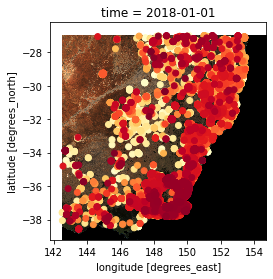

In [6]:
ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(vmax=4000)
hotspots_gdf.plot(ax=plt.gca(), column='datetime', cmap=fires_cmap)

## Generate animation frames

2019-09-01 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


2019-09-01 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-01 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-01 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-01 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-01 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-02 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-02 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-02 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-02 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-02 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-02 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-03 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-03 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-03 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-03 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-03 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-03 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-04 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-04 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-04 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-04 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-04 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-04 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-05 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-05 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-05 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-05 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-05 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-05 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-06 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-06 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-06 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-06 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-06 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-06 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-07 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-07 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-07 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-07 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-07 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-07 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-08 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-08 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-08 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-08 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-08 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-08 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-09 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-09 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-09 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-09 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-09 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-09 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-10 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-10 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-10 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-10 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-10 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-10 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-11 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-11 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-11 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-11 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-11 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-11 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-12 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-12 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-12 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-12 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-12 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-12 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-13 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-13 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-13 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-13 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-13 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-13 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-14 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-14 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-14 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-14 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-14 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-14 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-15 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-15 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-15 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-15 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-15 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-15 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-16 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-16 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-16 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-16 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-16 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-16 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-17 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-17 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-17 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-17 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-17 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-17 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-18 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-18 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-18 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-18 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-18 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-18 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-19 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-19 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-19 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-19 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-19 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-19 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-20 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-20 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-20 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-20 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-20 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-20 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-21 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-21 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-21 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-21 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-21 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-21 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-22 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-22 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-22 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-22 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-22 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-22 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-23 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-23 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-23 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-23 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-23 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-23 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-24 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-24 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-24 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-24 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-24 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-24 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-25 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-25 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-25 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-25 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-25 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-25 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-26 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-26 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-26 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-26 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-26 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-26 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-27 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-27 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-27 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-27 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-27 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-27 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-28 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-28 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-28 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-28 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-28 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-28 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-29 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-29 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-29 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-29 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-29 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-29 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-30 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-30 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-30 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-30 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-30 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-09-30 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-01 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-01 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-01 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-01 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-01 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-01 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-02 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-02 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-02 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-02 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-02 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-02 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-03 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-03 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-03 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-03 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-03 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-03 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-04 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-04 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-04 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-04 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-04 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-04 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-05 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-05 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-05 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-05 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-05 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-05 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-06 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-06 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-06 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-06 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-06 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-06 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-07 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-07 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-07 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-07 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-07 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-07 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-08 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-08 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-08 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-08 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-08 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-08 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-09 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-09 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-09 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-09 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-09 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-09 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-10 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-10 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-10 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-10 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-10 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-10 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-11 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-11 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-11 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-11 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-11 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-11 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-12 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-12 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-12 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-12 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-12 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-12 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-13 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-13 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-13 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-13 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-13 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-13 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-14 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-14 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-14 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-14 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-14 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-14 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-15 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-15 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-15 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-15 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-15 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-15 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-16 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-16 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-16 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-16 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-16 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-16 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-17 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-17 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-17 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-17 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-17 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-17 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-18 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-18 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-18 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-18 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-18 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-18 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-19 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-19 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-19 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-19 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-19 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-19 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-20 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-20 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-20 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-20 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-20 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-20 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-21 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-21 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-21 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-21 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-21 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-21 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-22 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-22 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-22 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-22 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-22 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-22 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-23 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-23 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-23 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-23 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-23 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-23 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-24 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-24 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-24 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-24 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-24 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-24 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-25 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-25 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-25 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-25 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-25 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-25 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-26 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-26 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-26 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-26 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-26 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-26 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-27 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-27 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-27 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-27 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-27 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-27 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-28 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-28 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-28 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-28 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-28 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-28 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-29 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-29 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-29 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-29 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-29 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-29 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-30 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-30 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-30 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-30 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-30 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-30 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-31 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-31 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-31 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-31 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-31 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-31 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-01 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-01 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-01 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-01 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-01 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-01 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-02 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-02 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-02 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-02 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-02 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-02 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-03 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-03 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-03 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-03 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-03 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-03 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-04 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-04 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-04 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-04 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-04 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-04 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-05 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-05 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-05 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-05 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-05 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-05 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-06 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-06 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-06 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-06 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-06 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-06 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-07 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-07 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-07 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-07 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-07 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-07 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-08 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-08 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-08 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-08 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-08 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-08 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-09 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-09 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-09 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-09 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-09 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-09 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-10 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-10 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-10 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-10 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-10 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-10 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-11 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-11 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-11 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-11 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-11 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-11 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-12 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-12 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-12 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-12 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-12 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-12 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-13 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-13 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-13 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-13 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-13 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-13 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-14 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-14 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-14 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-14 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-14 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-14 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-15 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-15 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-15 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-15 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-15 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-15 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-16 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-16 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-16 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-16 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-16 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-16 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-17 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-17 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-17 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-17 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-17 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-17 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-18 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-18 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-18 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-18 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-18 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-18 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-19 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-19 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-19 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-19 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-19 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-19 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-20 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-20 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-20 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-20 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-20 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-20 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-21 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-21 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-21 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-21 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-21 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-21 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-22 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-22 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-22 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-22 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-22 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-22 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-23 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-23 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-23 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-23 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-23 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-23 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-24 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-24 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-24 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-24 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-24 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-24 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-25 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-25 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-25 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-25 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-25 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-25 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-26 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-26 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-26 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-26 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-26 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-26 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-27 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-27 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-27 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-27 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-27 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-27 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-28 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-28 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-28 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-28 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-28 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-28 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-29 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-29 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-29 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-29 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-29 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-29 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-30 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-30 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-30 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-30 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-30 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-30 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-01 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-01 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-01 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-01 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-01 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-01 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-02 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-02 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-02 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-02 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-02 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-02 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-03 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-03 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-03 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-03 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-03 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-03 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-04 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-04 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-04 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-04 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-04 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-04 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-05 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-05 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-05 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-05 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-05 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-05 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-06 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-06 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-06 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-06 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-06 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-06 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-07 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-07 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-07 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-07 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-07 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-07 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-08 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-08 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-08 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-08 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-08 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-08 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-09 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-09 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-09 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-09 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-09 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-09 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-10 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-10 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-10 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-10 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-10 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-10 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-11 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-11 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-11 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-11 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-11 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-11 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-12 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-12 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-12 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-12 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-12 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-12 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-13 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-13 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-13 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-13 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-13 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-13 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-14 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-14 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-14 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-14 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-14 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-14 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-15 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-15 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-15 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-15 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-15 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-15 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-16 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-16 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-16 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-16 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-16 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-16 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-17 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-17 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-17 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-17 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-17 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-17 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-18 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-18 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-18 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-18 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-18 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-18 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-19 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-19 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-19 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-19 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-19 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-19 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-20 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-20 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-20 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-20 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-20 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-20 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-21 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-21 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-21 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-21 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-21 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-21 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-22 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-22 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-22 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-22 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-22 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-22 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-23 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-23 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-23 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-23 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-23 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-23 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-24 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-24 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-24 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-24 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-24 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-24 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-25 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-25 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-25 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-25 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-25 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-25 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-26 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-26 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-26 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-26 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-26 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-26 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-27 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-27 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-27 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-27 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-27 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-27 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-28 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-28 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-28 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-28 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-28 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-28 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-29 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-29 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-29 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-29 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-29 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-29 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-30 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-30 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-30 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-30 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-30 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-30 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-31 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-31 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-31 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-31 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-31 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-31 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-01 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-01 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-01 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-01 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-01 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-01 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-02 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-02 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-02 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-02 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-02 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-02 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-03 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-03 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-03 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-03 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-03 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-03 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-04 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-04 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-04 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-04 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-04 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-04 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-05 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-05 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-05 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-05 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-05 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-05 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-06 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-06 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-06 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-06 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-06 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-06 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-07 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-07 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-07 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-07 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-07 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-07 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-08 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-08 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-08 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-08 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-08 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-08 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-09 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-09 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-09 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-09 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-09 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-09 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-10 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-10 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-10 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-10 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-10 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-10 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-11 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-11 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-11 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-11 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-11 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-11 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-12 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-29 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-29 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-29 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-29 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-29 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-30 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-30 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-30 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-30 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-30 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-30 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-31 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-31 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-31 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-31 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-31 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-31 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-01 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-01 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-01 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-01 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-01 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-01 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-02 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-02 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-02 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-02 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-02 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-02 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-03 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-03 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-03 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-03 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-03 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-03 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-04 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-04 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-04 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-04 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-04 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-04 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-05 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-05 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-05 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-05 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-05 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-05 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-06 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-06 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-06 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-06 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-06 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-06 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-07 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-07 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-07 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-07 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-07 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-07 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-08 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-08 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-08 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-08 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-08 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-08 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-09 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-09 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-09 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-09 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-09 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-09 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-10 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-10 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-10 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-10 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-10 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-10 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-11 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-11 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-11 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-11 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-11 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-11 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-12 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-12 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-12 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-12 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-12 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-12 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-13 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-13 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-13 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-13 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-13 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-13 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-14 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-14 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-14 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-14 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-14 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-14 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-15 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


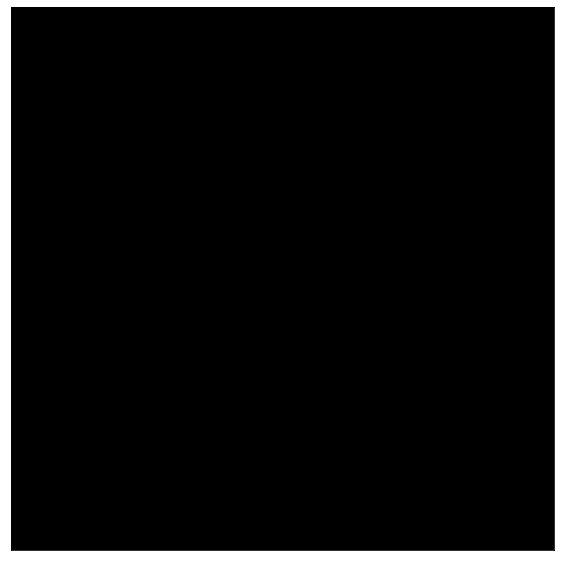

In [8]:
ds_ani = ds.copy(deep=True)

# If output folder doesn't exist, create it
output_dir = f'frames_{name}'
os.makedirs(output_dir, exist_ok=True)

# # Get date/times to iterate through (1 per frame)
# comp_dates = pd.date_range(hotspots_gdf.datetime.min(), 
#                            (dt.datetime.today() + dt.timedelta(days=0.7)), 
#                            freq=frame_freq)

# Get date/times to iterate through (1 per frame)
comp_dates = pd.date_range(from_date, 
                           to_date, 
                           freq=frame_freq)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, comp_date in enumerate(comp_dates):
    
    print(comp_date)

    # Extract only hotspots occuring prior to frame date/time
    hotspots_prev = hotspots_gdf.loc[
        hotspots_gdf['datetime'] < comp_date].copy()
    
    # Calculate hours between frame date and hotspot and sort
    hotspots_prev['hours_before'] = ((
        (comp_date - hotspots_prev['datetime'])).astype('timedelta64[m]') / 60)
    hotspots_prev.sort_values('hours_before', inplace=True, ascending=False)
    
    # Filter to most recent hours
    hotspots_prev = hotspots_prev[hotspots_prev.hours_before < fade_hours]

    # Plot Geomedian as underlay
    try:
        burnt_pixels = xr_rasterize(gdf=hotspots_prev, 
                                        da=ds.red, 
                                        x_dim='longitude', 
                                        y_dim='latitude',
                                        all_touched=True)
        ds_ani = ds_ani * (1 - burnt_pixels * 0.05)
    except:
        pass
    
    ds_ani[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(ax=ax, 
                                                                     vmax=4000)
    
    # Plot hotspots
    hotspots_prev.plot(ax=ax,
                       column='hours_before',
                       cmap=fires_cmap,
                       markersize=hotspots_markersize,
                       alpha=hotspots_alpha,
                       vmin=0,
                       vmax=fade_hours,
                      )
    
    boundary.plot(linestyle=':', edgecolor='white', facecolor='none', ax=plt.gca())
    
    labels = {'Sydney': (151.2093, -33.8688), 
              'Canberra': (149.1300, -35.2809), 
              'Melbourne': (144.9631, -37.8136)}

    for label, (x, y) in labels.items():
        plt.annotate(s=label,
                         xy=(x + 0.25, y), 
                         c='white',
                         fontname='Liberation Sans',
                         fontsize=10), 
    
    # Customise plot and add title
    ax.set_facecolor('black')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('');
    ax.text(0.03, 0.95,
            f"{comp_date.tz_localize(tz='UTC').tz_convert('Australia/Sydney'):%Y-%m-%d}",
            ha='left', 
            va='center', 
            transform=ax.transAxes,
           fontdict={'fontsize': 20, 
                     'color': 'white', 
                     'fontname':'Liberation Sans'})
    
    # Export frame to file
    fig.savefig(f'{output_dir}/hotspots_{i}.png', 
                bbox_inches='tight',
                dpi=100,
                pad_inches=0)
    plt.cla()


## Combine into MP4 animation using FFMPEG

In [9]:
!ffmpeg -y -r 24 -i $output_dir/hotspots_%d.png -c:v libx264 -vf crop=in_w-15:in_h-15 -pix_fmt yuv420p $output_dir/hotspots_animation.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [ ]:
!ffmpeg -y -r 24 -i $output_dir/hotspots_%d.png -vf crop=in_w-15:in_h-15,minterpolate=fps=7 $output_dir/hotspots_animation.gif

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)